### SM Hub Appetence scoring ppo model POC
- Following script is betaversion of modelling pipeline. 
- **This is not validated production version**.
- Validation process will be done with SM Hub management (David Thebault & Jacques Akponi)
- Validated version of this script should replace the current SM Hub SAS code.
- Feature selection process and scorecard development follow the methodology behind SAS solution.
- Documentation can be seen *here*
- Script developed by BISME TVS Member Josef Alb


#### Package Import
- all packages are industry-standard
- if the package is not presented on your JH run: *!pip install \<package_name\>*

In [2]:
# Importing all the necessary packages
import pandas as pd # data storage and manipulation
import numpy as np # numerical operations
from ydata_profiling import ProfileReport # relevant variables profiling
import os # operations on the system's level
from sklearn.linear_model import LogisticRegression # Modelling
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score # Model performance documentation
from sklearn.model_selection import train_test_split # splitting the data
from scipy.stats import chi2_contingency # categorical variables inspection
from statsmodels.stats.outliers_influence import variance_inflation_factor  # multicolinearity of numerical variables
from scipy.stats import kruskal, pearsonr, spearmanr # Relevancy of numerical variables, multicolin.
from sklearn.ensemble import RandomForestClassifier # binning algorith
from sklearn.feature_extraction import FeatureHasher # tool for labelling of discretized vartiables
from sklearn.preprocessing import LabelEncoder # tool for labelling of discretized vartiables
import statsmodels.api as sm
import warnings 
warnings.filterwarnings('ignore') # ignore warnings from pipeline if any
import prince
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import time 
import seaborn as sns

# 1. INFORMATION SUR LE JEU DE DONNEES

- La base contient 48357 enregistrements et 54 variables dont une categorielle qui est le genre (M/F)
- Il y a 7988 clients qui on souscrit au PPO soit 17 %  et 40369 qui n'ont pas souscrit soit 83%
- Les colonnes encours_ccQ0Q1, engag_pretsQ0Q1, encours_epplQ0Q1 sont de type object du fait de la presence de ? dans certaine lignes. Ces valeurs seront   remplacées par 0 et ces variables sont converties en numériques
- 


#### Data load
- checks the current working directory and loads the data from 'Data' folder
- **Path to the 'Data' folder has to be adjusted based on the user name** - i.e. change e_jalb for your login name

In [3]:
current_dir = os.getcwd()
print(f"JupyterLab currently in folder {current_dir}")
df_raw_data = pd.read_csv("base_finale2024.csv", decimal=",", delimiter=";", header=0)

JupyterLab currently in folder /home/e_ykouak/BISME/NAMORY/APPETENCE YELLOW


In [4]:
current_dir = os.getcwd()
print(f"JupyterLab currently in folder {current_dir}")

JupyterLab currently in folder /home/e_ykouak/BISME/NAMORY/APPETENCE YELLOW


In [5]:
pd.set_option("display.max_column",300)
pd.set_option("display.max_row",None)

In [6]:
#list(df_raw_data.columns)
df_raw_data.head()

,Party_Id,age,gender_code,encours_cc0,encours_cc1,encours_cc2,encours_cc3,encours_cc4,encours_cc5,encours_cc6,encours_cc7,encours_cc8,encours_cc9,encours_cc10,encours_cc11,encours_cc12,encours_cc_avg3,encours_cc_avg6,encours_cc_avg12,engag_prets0,engag_prets1,engag_prets2,engag_prets3,engag_prets4,engag_prets5,engag_prets6,engag_prets7,engag_prets8,engag_prets9,engag_prets10,engag_prets11,engag_prets12,engag_prets_avg3,engag_prets_avg6,engag_prets_avg12,encours_eppl0,encours_eppl1,encours_eppl2,encours_eppl3,encours_eppl4,encours_eppl5,encours_eppl6,encours_eppl7,encours_eppl8,encours_eppl9,encours_eppl10,encours_eppl11,encours_eppl12,encours_eppl_avg3,encours_eppl_avg6,encours_eppl_avg12,encours_ccQ0Q1,engag_pretsQ0Q1,encours_epplQ0Q1,Top_PPO
0,500516511,41,M,-5480.0,-4950.0,-5420.0,-5619.0,15343.0,-3879.0,1281.0,-2991.0,-2771.0,-576.0,-5348.0,-444.0,-4233.0,-5283.33,-1667.50,-1737.83,-5480.0,-4950.0,-5420.0,-5619.0,15343.0,-3879.0,1281.0,-2991.0,-2771.0,-576.0,-5348.0,-444.0,-4233.0,-5283.33,-1667.50,-1737.83,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-1.831400e+04,-1.831400e+04,-1.831400e+04,"-3,71","-3,71","0,00",0
1,500486501,43,M,-4270.0,-3908.0,-6037.0,-201.0,1635.0,-6508.0,11341.0,164989.0,5121.0,-4981.0,-7150.0,5333.0,-6916.0,-4738.33,-3214.83,12947.00,-4270.0,-3908.0,-6037.0,-201.0,1635.0,-6508.0,11341.0,164989.0,5121.0,-4981.0,-7150.0,5333.0,-6916.0,-4738.33,-3214.83,12947.00,25100.0,25100.0,25100.0,303100.0,373000.0,243000.0,375000.0,389089.0,275089.0,125089.0,30089.0,25496.0,25496.0,2.510000e+04,1.657333e+05,1.845210e+05,"1,80","1,80","-0,92",1
2,124013816,53,M,11921823.0,12234173.0,11435081.0,10940939.0,10772997.0,9970008.0,9246917.0,10188019.0,10598025.0,9849985.0,9007102.0,8052177.0,7279745.0,11863692.33,11212503.50,10351437.17,11921823.0,12234173.0,11435081.0,10940939.0,10772997.0,9970008.0,9246917.0,10188019.0,10598025.0,9849985.0,9007102.0,8052177.0,7279745.0,11863692.33,11212503.50,10351437.17,2666148.0,2668148.0,2668148.0,2668148.0,2591296.0,2601197.0,2601197.0,2603197.0,2603197.0,2603197.0,2605197.0,2605197.0,2605197.0,2.667481e+06,2.643848e+06,2.623689e+06,"0,12","0,12","0,02",0
3,119101277,70,M,91689159.0,96733909.0,98885115.0,71518623.0,71738349.0,74148105.0,94183894.0,93798904.0,84809198.0,66675855.0,70658785.0,40498860.0,50755893.0,95769394.33,84118876.67,79611563.00,91689159.0,96733909.0,98885115.0,71518623.0,71738349.0,74148105.0,94183894.0,93798904.0,84809198.0,66675855.0,70658785.0,40498860.0,50755893.0,95769394.33,84118876.67,79611563.00,209627524.0,208127524.0,206627524.0,205127524.0,200852325.0,199352325.0,197852325.0,195185358.0,193685358.0,192185358.0,190685358.0,189185358.0,187685358.0,2.081275e+08,2.049525e+08,1.990412e+08,"0,32","0,32","0,03",0
4,500540350,47,M,-86225.0,-79024.0,-78023.0,-82981.0,-61103.0,97014.0,-85907.0,-72792.0,-64620.0,-83451.0,-77313.0,105546.0,-74359.0,-81090.67,-48390.33,-47406.58,-258675.0,-237072.0,-234069.0,-248943.0,-183309.0,194028.0,-171814.0,-145584.0,-129240.0,-166902.0,-154626.0,211092.0,-148718.0,-243272.00,-161340.00,-127092.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,"4,17","2,06",?,0


In [7]:
df_raw_data[df_raw_data.isnull().any(axis=1)]

,Party_Id,age,gender_code,encours_cc0,encours_cc1,encours_cc2,encours_cc3,encours_cc4,encours_cc5,encours_cc6,encours_cc7,encours_cc8,encours_cc9,encours_cc10,encours_cc11,encours_cc12,encours_cc_avg3,encours_cc_avg6,encours_cc_avg12,engag_prets0,engag_prets1,engag_prets2,engag_prets3,engag_prets4,engag_prets5,engag_prets6,engag_prets7,engag_prets8,engag_prets9,engag_prets10,engag_prets11,engag_prets12,engag_prets_avg3,engag_prets_avg6,engag_prets_avg12,encours_eppl0,encours_eppl1,encours_eppl2,encours_eppl3,encours_eppl4,encours_eppl5,encours_eppl6,encours_eppl7,encours_eppl8,encours_eppl9,encours_eppl10,encours_eppl11,encours_eppl12,encours_eppl_avg3,encours_eppl_avg6,encours_eppl_avg12,encours_ccQ0Q1,engag_pretsQ0Q1,encours_epplQ0Q1,Top_PPO


In [9]:
df_raw_data["encours_ccQ0Q1"].replace("?", 0, inplace = True)
df_raw_data["encours_epplQ0Q1"].replace("?", 0, inplace = True)
df_raw_data["engag_pretsQ0Q1"].replace("?", 0, inplace = True)

In [11]:
df_raw_data.isnull().sum()

Party_Id              0
age                   0
gender_code           0
encours_cc0           0
encours_cc1           0
encours_cc2           0
encours_cc3           0
encours_cc4           0
encours_cc5           0
encours_cc6           0
encours_cc7           0
encours_cc8           0
encours_cc9           0
encours_cc10          0
encours_cc11          0
encours_cc12          0
encours_cc_avg3       0
encours_cc_avg6       0
encours_cc_avg12      0
engag_prets0          0
engag_prets1          0
engag_prets2          0
engag_prets3          0
engag_prets4          0
engag_prets5          0
engag_prets6          0
engag_prets7          0
engag_prets8          0
engag_prets9          0
engag_prets10         0
engag_prets11         0
engag_prets12         0
engag_prets_avg3      0
engag_prets_avg6      0
engag_prets_avg12     0
encours_eppl0         0
encours_eppl1         0
encours_eppl2         0
encours_eppl3         0
encours_eppl4         0
encours_eppl5         0
encours_eppl6   

#### Custom functions definition
- Functions bellow serves for basic data cleaning 
- most of data cleaning operations is done on extraction level
- remove_single_value_columns - as discussed on monday, this function removes single-value columns. Single value columns won't pass Kruskal-Wallis statistic.

In [12]:
def remove_single_value_columns(df):
    '''Removing single value columns - no variance means weak relationship with targe and therefore obsolete feature.
    # examine the possibility of corr with targety later!! 
    '''
    columns_to_remove = df.columns[df.nunique() == 1]
    print(f"Columns dropped: {list(columns_to_remove)}")
    return df.loc[:, df.nunique()>1]

def remove_duplicates(df):
    '''Removing duplicit values - due to party_id we don't suppose there will be many duplicates.'''
    cleaned_df = df.drop_duplicates().reset_index(drop = True)
    return cleaned_df

def convert_object_cols_to_numeric(df, prefixes):
    '''Obsolete function - may be deleted until release.'''
    for prefix in prefixes:
        matching_columns = [col for col in df.columns if col.startswith(prefix)]
        for col in matching_columns:
            df[col] = pd.to_numeric(df[col], errors = 'raise')
            
def append_dict_to_df(df,dict_to_append):
    '''Appending ddataframe with data for metric/feature pairs.'''
    df = pd.concat([df, pd.DataFrame.from_records([dict_to_append])], ignore_index = True)
    return df

In [13]:
df_raw_data = remove_single_value_columns(df_raw_data)
cleaned_df = remove_duplicates(df_raw_data)

Columns dropped: []


In [16]:
df_raw_data = remove_single_value_columns(df_raw_data)
cleaned_df = remove_duplicates(df_raw_data)

Columns dropped: []


In [15]:
cleaned_df.head()

,Party_Id,age,gender_code,encours_cc0,encours_cc1,encours_cc2,encours_cc3,encours_cc4,encours_cc5,encours_cc6,encours_cc7,encours_cc8,encours_cc9,encours_cc10,encours_cc11,encours_cc12,encours_cc_avg3,encours_cc_avg6,encours_cc_avg12,engag_prets0,engag_prets1,engag_prets2,engag_prets3,engag_prets4,engag_prets5,engag_prets6,engag_prets7,engag_prets8,engag_prets9,engag_prets10,engag_prets11,engag_prets12,engag_prets_avg3,engag_prets_avg6,engag_prets_avg12,encours_eppl0,encours_eppl1,encours_eppl2,encours_eppl3,encours_eppl4,encours_eppl5,encours_eppl6,encours_eppl7,encours_eppl8,encours_eppl9,encours_eppl10,encours_eppl11,encours_eppl12,encours_eppl_avg3,encours_eppl_avg6,encours_eppl_avg12,encours_ccQ0Q1,engag_pretsQ0Q1,encours_epplQ0Q1,Top_PPO
0,500516511,41,M,-5480.0,-4950.0,-5420.0,-5619.0,15343.0,-3879.0,1281.0,-2991.0,-2771.0,-576.0,-5348.0,-444.0,-4233.0,-5283.33,-1667.50,-1737.83,-5480.0,-4950.0,-5420.0,-5619.0,15343.0,-3879.0,1281.0,-2991.0,-2771.0,-576.0,-5348.0,-444.0,-4233.0,-5283.33,-1667.50,-1737.83,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-18314.0,-1.831400e+04,-1.831400e+04,-1.831400e+04,"-3,71","-3,71","0,00",0
1,500486501,43,M,-4270.0,-3908.0,-6037.0,-201.0,1635.0,-6508.0,11341.0,164989.0,5121.0,-4981.0,-7150.0,5333.0,-6916.0,-4738.33,-3214.83,12947.00,-4270.0,-3908.0,-6037.0,-201.0,1635.0,-6508.0,11341.0,164989.0,5121.0,-4981.0,-7150.0,5333.0,-6916.0,-4738.33,-3214.83,12947.00,25100.0,25100.0,25100.0,303100.0,373000.0,243000.0,375000.0,389089.0,275089.0,125089.0,30089.0,25496.0,25496.0,2.510000e+04,1.657333e+05,1.845210e+05,"1,80","1,80","-0,92",1
2,124013816,53,M,11921823.0,12234173.0,11435081.0,10940939.0,10772997.0,9970008.0,9246917.0,10188019.0,10598025.0,9849985.0,9007102.0,8052177.0,7279745.0,11863692.33,11212503.50,10351437.17,11921823.0,12234173.0,11435081.0,10940939.0,10772997.0,9970008.0,9246917.0,10188019.0,10598025.0,9849985.0,9007102.0,8052177.0,7279745.0,11863692.33,11212503.50,10351437.17,2666148.0,2668148.0,2668148.0,2668148.0,2591296.0,2601197.0,2601197.0,2603197.0,2603197.0,2603197.0,2605197.0,2605197.0,2605197.0,2.667481e+06,2.643848e+06,2.623689e+06,"0,12","0,12","0,02",0
3,119101277,70,M,91689159.0,96733909.0,98885115.0,71518623.0,71738349.0,74148105.0,94183894.0,93798904.0,84809198.0,66675855.0,70658785.0,40498860.0,50755893.0,95769394.33,84118876.67,79611563.00,91689159.0,96733909.0,98885115.0,71518623.0,71738349.0,74148105.0,94183894.0,93798904.0,84809198.0,66675855.0,70658785.0,40498860.0,50755893.0,95769394.33,84118876.67,79611563.00,209627524.0,208127524.0,206627524.0,205127524.0,200852325.0,199352325.0,197852325.0,195185358.0,193685358.0,192185358.0,190685358.0,189185358.0,187685358.0,2.081275e+08,2.049525e+08,1.990412e+08,"0,32","0,32","0,03",0
4,500540350,47,M,-86225.0,-79024.0,-78023.0,-82981.0,-61103.0,97014.0,-85907.0,-72792.0,-64620.0,-83451.0,-77313.0,105546.0,-74359.0,-81090.67,-48390.33,-47406.58,-258675.0,-237072.0,-234069.0,-248943.0,-183309.0,194028.0,-171814.0,-145584.0,-129240.0,-166902.0,-154626.0,211092.0,-148718.0,-243272.00,-161340.00,-127092.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,"4,17","2,06",0,0


#### Data Splitting
- Accoring to parameters from SAS:
    - 70/30 ration (70 training/30 testing)
    - Stratified sampling
    - Random State = 42 

In [66]:
##################################"

x = cleaned_df.drop(['Top_PPO'], axis = 1) # top churn = target variable
y = cleaned_df['Top_PPO']
x_Train, x_Test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 42)

# Extract Party_ID it could bias the results
x_id = x_Train['Party_Id']
x_Train = x_Train.drop(['Party_Id'], axis = 1)
y_id = x_Test['Party_Id']
x_Test = x_Test.drop(['Party_Id'], axis = 1)

In [67]:
x_Train.head()

,age,gender_code,encours_cc0,encours_cc1,encours_cc2,encours_cc3,encours_cc4,encours_cc5,encours_cc6,encours_cc7,encours_cc8,encours_cc9,encours_cc10,encours_cc11,encours_cc12,encours_cc_avg3,encours_cc_avg6,encours_cc_avg12,engag_prets0,engag_prets1,engag_prets2,engag_prets3,engag_prets4,engag_prets5,engag_prets6,engag_prets7,engag_prets8,engag_prets9,engag_prets10,engag_prets11,engag_prets12,engag_prets_avg3,engag_prets_avg6,engag_prets_avg12,encours_eppl0,encours_eppl1,encours_eppl2,encours_eppl3,encours_eppl4,encours_eppl5,encours_eppl6,encours_eppl7,encours_eppl8,encours_eppl9,encours_eppl10,encours_eppl11,encours_eppl12,encours_eppl_avg3,encours_eppl_avg6,encours_eppl_avg12,encours_ccQ0Q1,engag_pretsQ0Q1,encours_epplQ0Q1
34445,41,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0,0,0
32591,43,M,1480560.0,1495360.0,1641360.0,1216158.0,1111239.0,1241957.0,1360107.0,952857.0,1321007.0,865491.0,420291.0,1951041.0,996377.0,1539093.33,1364439.00,1254785.67,1480560.0,1495360.0,1641360.0,1216158.0,1111239.0,1241957.0,1360107.0,952857.0,1321007.0,865491.0,420291.0,1951041.0,996377.0,1539093.33,1364439.00,1254785.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194541.0,0.00,0.00,0.0,"0,29","0,29",0
6561,33,M,695494.0,155437.0,115141.0,-103197.0,-182094.0,21873.0,710034.0,-68558.0,97087.0,39927.0,435203.0,600979.0,68889.0,322024.00,117109.00,209777.17,1392968.0,312854.0,232262.0,-102207.0,-181104.0,22863.0,711024.0,-67568.0,98077.0,40917.0,436193.0,601969.0,69879.0,646028.00,279606.00,291520.67,31353.0,31353.0,31353.0,31353.0,306407.0,231407.0,255214.0,855214.0,755214.0,665114.0,565114.0,465114.0,365114.0,31353.00,110537.67,352017.5,"-4,67","-8,44","-0,83"
46188,68,M,89974.0,253474.0,403474.0,528374.0,589145.0,559816.0,675537.0,686308.0,602029.0,719550.0,840221.0,761492.0,791813.0,248974.00,404042.83,559116.17,89974.0,253474.0,403474.0,528374.0,589145.0,559816.0,675537.0,686308.0,602029.0,719550.0,840221.0,761492.0,791813.0,248974.00,404042.83,559116.17,1562520.0,1530388.0,1523388.0,1527983.0,1527983.0,1677983.0,1632410.0,1632410.0,1632410.0,1635686.0,1602879.0,1570116.0,1522096.0,1538765.33,1558374.17,1588013.0,"-0,55","-0,55","-0,02"
32708,61,M,5518766.0,2780766.0,2496466.0,13192666.0,11661516.0,5173066.0,9186416.0,9197966.0,3709516.0,1987066.0,1998616.0,2010166.0,2021716.0,3598666.00,6803874.33,5742749.33,5518766.0,2780766.0,2496466.0,13192666.0,11661516.0,5173066.0,9186416.0,9197966.0,3709516.0,1987066.0,1998616.0,2010166.0,2021716.0,3598666.00,6803874.33,5742749.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,"-0,64","-0,64",0


In [71]:
x_Train[x_Train["engag_pretsQ0Q1"]==0].head()

,age,gender_code,encours_cc0,encours_cc1,encours_cc2,encours_cc3,encours_cc4,encours_cc5,encours_cc6,encours_cc7,encours_cc8,encours_cc9,encours_cc10,encours_cc11,encours_cc12,encours_cc_avg3,encours_cc_avg6,encours_cc_avg12,engag_prets0,engag_prets1,engag_prets2,engag_prets3,engag_prets4,engag_prets5,engag_prets6,engag_prets7,engag_prets8,engag_prets9,engag_prets10,engag_prets11,engag_prets12,engag_prets_avg3,engag_prets_avg6,engag_prets_avg12,encours_eppl0,encours_eppl1,encours_eppl2,encours_eppl3,encours_eppl4,encours_eppl5,encours_eppl6,encours_eppl7,encours_eppl8,encours_eppl9,encours_eppl10,encours_eppl11,encours_eppl12,encours_eppl_avg3,encours_eppl_avg6,encours_eppl_avg12,encours_ccQ0Q1,engag_pretsQ0Q1,encours_epplQ0Q1
34445,41,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0,0,0
20391,27,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,437767.0,313767.0,358767.0,563767.0,598767.0,378831.0,329527.0,339527.0,246235.0,261235.0,91235.0,154316.0,209316.0,370100.33,441944.33,339478.42,0,0,"-0,28"
17201,29,M,52720.0,2714.0,152707.0,22700.0,282854.0,108110.0,8103.0,8097.0,153132.0,1898125.0,0.0,0.0,0.0,69380.33,103634.17,224105.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3563946.0,3813946.0,3413946.0,3113946.0,1690100.0,1475000.0,1175000.0,1175000.0,545000.0,0.0,0.0,0.0,0.0,3597279.33,2845147.33,1663823.67,"-0,50",0,"0,72"
12858,30,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0,0,0
40353,34,F,8080.0,135935.0,161788.0,195643.0,9497.0,13352.0,7206.0,6060.0,9914.0,3768.0,329568.0,8475.0,14216.0,101934.33,87382.50,74107.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134106.0,134106.0,114106.0,94106.0,74106.0,54106.0,74106.0,54106.0,104106.0,204106.0,180024.0,229924.0,289924.0,127439.33,100772.67,120917.33,"0,40",0,"0,72"


In [72]:
x_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33434 entries, 34445 to 14440
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 33434 non-null  int64  
 1   gender_code         33434 non-null  object 
 2   encours_cc0         33434 non-null  float64
 3   encours_cc1         33434 non-null  float64
 4   encours_cc2         33434 non-null  float64
 5   encours_cc3         33434 non-null  float64
 6   encours_cc4         33434 non-null  float64
 7   encours_cc5         33434 non-null  float64
 8   encours_cc6         33434 non-null  float64
 9   encours_cc7         33434 non-null  float64
 10  encours_cc8         33434 non-null  float64
 11  encours_cc9         33434 non-null  float64
 12  encours_cc10        33434 non-null  float64
 13  encours_cc11        33434 non-null  float64
 14  encours_cc12        33434 non-null  float64
 15  encours_cc_avg3     33434 non-null  float64
 16  encou

In [74]:
cols = ['encours_ccQ0Q1', 'engag_pretsQ0Q1', 'encours_epplQ0Q1']
x_Test
# Conversion des colonnes en numérique
for col in cols:
    x_Train[col] = pd.to_numeric(x_Train[col], errors='coerce')
    x_Test[col] = pd.to_numeric(x_Test[col], errors='coerce')

In [76]:
# Preparing dataframes for report and comparison of IV and CV
selected_columns_category = []
iv_df = pd.DataFrame(columns = ['Feature','IV'])
cramer_v_df = pd.DataFrame(columns = ['Feature','CV'])

#### Bi-Variate analysis for Categorical features
- Definition of function for Cramer's V
- Definition of function for Inofrmation Value
- Set threshold and run the functions for categorical dataset
- Store the most relevant features in **selected_columns_category**
- Ingest only relevant categorical columns from x_Train to **x_Train_rel_features** 

In [84]:
# Define functions for categorical features selection. Cramer's V (CV) and Information Value (IV) / Weight of evidence
def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr)))

def calculate_iv(df, categorical_column, target_series):
    crosstab = pd.crosstab(df[categorical_column], target_series)
    total_good = target_series.sum()
    total_bad = crosstab[0].sum()
    iv = 0
    
    for category,row in crosstab.iterrows():
        good = row[1]
        bad = row[0]
        if good == 0 or bad == 0:
            contribution = 0
        else:
            good_pct = good / total_good
            bad_pct = bad / total_bad
            contribution = (good_pct - bad_pct) * np.log(good_pct / bad_pct)
        iv += contribution
    return iv

In [85]:
# Preparing dataframes for report and comparison of IV and CV
selected_columns_category = []
iv_df = pd.DataFrame(columns = ['Feature','IV'])
cramer_v_df = pd.DataFrame(columns = ['Feature','CV'])

In [87]:
# Variables categoriales
categorical_features

#### Bi-Variate analysis for numerical features
- based on SAS input
- using Kruskal-Wallis test for relevancy of variables
- possibility to add other statistic like pearson, spearman etc.

In [90]:
kruskal_df = pd.DataFrame(columns = ['Feature','kruskal_stat', 'p-val'])
selected_columns_numeric = []
for numerical_feature in numerical_features:
    statistic, p_value = kruskal(*[group for name, group in x_Train.groupby(y_train)[numerical_feature]])
    kruskal_df = append_dict_to_df(kruskal_df, {'Feature': numerical_feature, 'kruskal_stat':statistic, 'p-val': p_value})   
    
    if statistic > 0.05 and p_value < 0.01  :
        selected_columns_numeric.append(numerical_feature)

In [91]:
selected_columns_numeric

['age',
 'encours_cc0',
 'encours_cc1',
 'encours_cc2',
 'encours_cc3',
 'encours_cc4',
 'encours_cc5',
 'encours_cc6',
 'encours_cc7',
 'encours_cc8',
 'encours_cc9',
 'encours_cc10',
 'encours_cc11',
 'encours_cc12',
 'encours_cc_avg3',
 'encours_cc_avg6',
 'encours_cc_avg12',
 'engag_prets0',
 'engag_prets1',
 'engag_prets2',
 'engag_prets3',
 'engag_prets4',
 'engag_prets5',
 'engag_prets6',
 'engag_prets7',
 'engag_prets8',
 'engag_prets9',
 'engag_prets10',
 'engag_prets11',
 'engag_prets12',
 'engag_prets_avg3',
 'engag_prets_avg6',
 'engag_prets_avg12',
 'encours_eppl0',
 'encours_eppl1',
 'encours_eppl2',
 'encours_eppl3',
 'encours_eppl4',
 'encours_eppl5',
 'encours_eppl6',
 'encours_eppl_avg3']

In [92]:
kruskal_df

,Feature,kruskal_stat,p-val
0,age,436.492769,6.277137e-97
1,encours_cc0,315.997007,1.078591e-70
2,encours_cc1,149.839413,1.879578e-34
3,encours_cc2,151.898053,6.669715e-35
4,encours_cc3,94.705210,2.209569e-22
5,encours_cc4,162.115360,3.903786e-37
6,encours_cc5,166.174109,5.067968e-38
7,encours_cc6,137.865383,7.798837e-32
8,encours_cc7,133.261402,7.925783e-31
9,encours_cc8,218.373954,2.046781e-49


In [93]:
# Compiling data into one dataset
x_Train_num = x_Train[selected_columns_numeric]
x_Train_cat = x_Train[selected_columns_category]
x_Test_cat = x_Test[selected_columns_category]
x_Train_rel_features = x_Train_cat.join(x_Train_num, how = 'inner')

In [12]:
# # New dataset division - in order to categorize numerical variable in subsequent step
# categorical_features = []
# numerical_features = []

# for column in x_Train.columns:
#     if x_Train[column].dtype == 'object':
#         categorical_features.append(column)
#     else:
#         numerical_features.append(column)

#### Multicolinearity - Numerical variables
- Calculation of VIF, Pearson, Spearman coefficients for each pair of num variable
- In next step, impose the treshold for VIF based on VIF value (10) or Tolerance (0.2)
- In SAS script there is no threshold for Spearman/Pearson - but all three are in the final report (maybe it serves as auxilliary data)
- I.e. it's easy to impose threshold also on Spearman/Pearson since calculation for both is done in this substep

In [94]:
# Pearson,Spearman,VIF for numerical variables
x_Train_rel_num_features = x_Train_rel_features[selected_columns_numeric]
VIF_df = pd.DataFrame()
Pearson_df = pd.DataFrame() 
Spearman_df = pd.DataFrame()
processed_pairs = set()

for variable in selected_columns_numeric:   
    
    #Calculate VIF
    vif = variance_inflation_factor(x_Train_rel_num_features.values,x_Train_rel_num_features.columns.get_loc(variable))
    Tolerance = 1 / vif
    VIF_df = append_dict_to_df(VIF_df, {'Feature':variable, 'VIF': vif, 'Tolerance': Tolerance})  
    
    #Pearson and Spearman 
    pearson_correlations = []
    spearman_correlations = []
    for other_variable in selected_columns_numeric:
        if variable != other_variable and (variable,other_variable) not in processed_pairs and (other_variable, variable) not in processed_pairs :
            pearson_corr = pearsonr(x_Train_rel_num_features[variable], x_Train_rel_num_features[other_variable])[0]
            Pearson_df = append_dict_to_df(Pearson_df, {'Feature':variable, 'PairVariable' : other_variable,'PearsonCorr': pearson_corr, 'PearsonCorrAbs': abs(pearson_corr)})
            spearman_corr = spearmanr(x_Train_rel_num_features[variable], x_Train_rel_num_features[other_variable])[0]
            Spearman_df = append_dict_to_df(Spearman_df, {'Feature':variable, 'PairVariable' : other_variable,'SpearmanCorr': spearman_corr, 'SpearmanCorrAbs': abs(spearman_corr)})
            processed_pairs.add((variable, other_variable))    

In [95]:
Pearson_df.head()

,Feature,PairVariable,PearsonCorr,PearsonCorrAbs
0,age,encours_cc0,0.152868,0.152868
1,age,encours_cc1,0.158222,0.158222
2,age,encours_cc2,0.155347,0.155347
3,age,encours_cc3,0.150290,0.150290
4,age,encours_cc4,0.157794,0.157794


In [96]:
Spearman_df.head()

,Feature,PairVariable,SpearmanCorr,SpearmanCorrAbs
0,age,encours_cc0,0.211277,0.211277
1,age,encours_cc1,0.217787,0.217787
2,age,encours_cc2,0.206522,0.206522
3,age,encours_cc3,0.217749,0.217749
4,age,encours_cc4,0.215784,0.215784


In [97]:
# Tolerance version
#VIF_Threshold = 0.2
#nonmulticol_numerical_variables = VIF_df[VIF_df['Tolerance'] >= VIF_Threshold]['Feature']
#x_Train_Num_MultiCol = x_Train_rel_features[nonmulticol_numerical_variables]
VIF_Threshold = 10
nonmulticol_numerical_variables = VIF_df[VIF_df['VIF'] <= VIF_Threshold]['Feature']
x_Train_Num_MultiCol = x_Train_rel_features[nonmulticol_numerical_variables]

#### Multicolinearity - Categorical variables
- In the first step define the functions for Pairwise CramerV (i.e. incorporating the mechanism from bivariate analysis so it examines the correlation for all variable pairs)
- In the Cramer_V_Subprocedure the multicolinear pairs are processed - and one variable with Higher Cramer V with respect to Target is chosen - the sceond is being dropped 

In [99]:
def Pairwise_Cramer_V(df):
    """Calculates Cramer's V for pre-selected variables. Is part of feature engineering in order to select relevant categorical features."""
    columns = df.columns
    cramer_v_matrix = np.zeros((len(columns),len(columns)))

    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            cramer_v = cramers_v(df[columns[i]], df[columns[j]])
            cramer_v_matrix[i, j] = cramer_v
            cramer_v_matrix[j, i] = cramer_v
    cramer_v_df = pd.DataFrame(cramer_v_matrix, index = columns, columns = columns)
    return cramer_v_df

def Cramer_V_subprocedure(df, bivariate_cramer_v_df, threshold):
    """Selects the Cramer's V according to threshold and checks which one from the pair have larger impact on the target. Feature with less relevancy is ommited from further processing"""
    pairwise_cramer_v  = Pairwise_Cramer_V(df)
    nonmulticol_categorical_variables = list(pairwise_cramer_v.columns)
    selected_var = None

    for i in range(len(pairwise_cramer_v)):
        for j in range(i+1, len(pairwise_cramer_v.columns)):
            cramer_v_value = pairwise_cramer_v.iat[i, j]
            var_to_remove = None
            cv_i = 0
            cv_j = 0
            
            if cramer_v_value < threshold:
                if pairwise_cramer_v.columns[i] not in nonmulticol_categorical_variables:
                    nonmulticol_categorical_variables.append(pairwise_cramer_v.columns[i])
                if pairwise_cramer_v.columns[j] not in nonmulticol_categorical_variables:
                    nonmulticol_categorical_variables.append(pairwise_cramer_v.columns[j])
            elif cramer_v_value >= threshold:
                cv_i = bivariate_cramer_v_df[bivariate_cramer_v_df['Feature'] == pairwise_cramer_v.columns[i]]['CV'].iloc[0]
                cv_j = bivariate_cramer_v_df[bivariate_cramer_v_df['Feature'] == pairwise_cramer_v.columns[j]]['CV'].iloc[0]

                if cv_i > cv_j:
                    selected_var = pairwise_cramer_v.columns[i]
                    var_to_remove = pairwise_cramer_v.columns[j]
                    
                else:
                    selected_var = pairwise_cramer_v.columns[j]
                    var_to_remove = pairwise_cramer_v.columns[i]
                
                if var_to_remove in nonmulticol_categorical_variables:
                    nonmulticol_categorical_variables.remove(var_to_remove)
                else:
                    nonmulticol_categorical_variables.remove(var_to_remove)
                    
    return nonmulticol_categorical_variables

In [100]:
nonmulticol_categorical_variables = []
nonmulticol_categorical_variables = Cramer_V_subprocedure(x_Train_cat, cramer_v_df, 0.6)
x_Train_Cat_MultiCol = x_Train_rel_features[nonmulticol_categorical_variables]
x_Test_Cat_MultiCol = x_Test[nonmulticol_categorical_variables]
pairwise_cramer_v = Pairwise_Cramer_V(x_Train_cat)

In [105]:
nonmulticol_categorical_variables

[]

#### Discretization & Feature Encoding
- Discretization of numerical variables
    - based on Regression Tree algorithm (not on  Ward's agglomerative hierarchical clustering as in SAS) with number of leaf = 4
    - **Number of leafs has impact on model performace** - so far we choose 4 but for other entities different threshold may be applied
    - Data about intervals are stored in bin_info
    - Identical binning scheme is applied on x_Test
    - Discretized columns have "_D" suffix
- Encoding of categorical features
    - In order to fit log reg we encode categorical features
    - origina value and new value for feature is stored in mapping_df 

In [103]:
# from sklearn.cluster import AgglomerativeClustering

# for feature in x_Train_Num_MultiCol.columns:
#     x_Train_Num_MultiCol[feature + '_Q'] = pd.qcut(x_Train_Num_MultiCol[feature].rank(method = 'first'), q = 4, labels = False, duplicates = 'drop')
#     cluster = AgglomerativeClustering(n_clusters = None, distance_threshold = 0, affinity = 'euclidean', linkage = 'ward')
#     x_Train_Num_MultiCol[feature + '_D'] = cluster.fit_predict(x_Train_Num_MultiCol[[feature + '_Q']])

# Binning using tree-based algorithm
from sklearn.tree import DecisionTreeRegressor
bin_info_df = pd.DataFrame(columns = ['Feature', 'Bin', 'Min', 'Max'])
for feature in x_Train_Num_MultiCol:
    tree = DecisionTreeRegressor(max_leaf_nodes = 4)
    tree.fit(x_Train_Num_MultiCol[[feature]], y_train)
    x_Train_Num_MultiCol[feature + '_D'] = tree.apply(x_Train_Num_MultiCol[[feature]])
    x_Test[feature + '_D'] = tree.apply(x_Test[[feature]]) # apply binning scheme also on x_Test variable

    unique_bins = x_Train_Num_MultiCol[feature + '_D'].unique()
    bin_borders = []
    
    for bin_num in unique_bins:
        bin_data = x_Train_Num_MultiCol[x_Train_Num_MultiCol[feature + '_D'] == bin_num][feature]
        bin_min = bin_data.min()
        bin_max = bin_data.max()
        bin_borders.append((bin_min,bin_max))
        bin_info_df = append_dict_to_df(bin_info_df, {'Feature': feature, 'Bin': bin_num, 'Min':bin_min, 'Max':bin_max})        

In [104]:
# Encoding categorical variables
label_encoder = LabelEncoder()

# cover all values for all relevant attributes
combined_df = pd.concat([x_Train_Cat_MultiCol, x_Test_Cat_MultiCol], axis = 0)
mapping_df = pd.DataFrame()
    
for col in nonmulticol_categorical_variables:
    label_encoder.fit(combined_df[col])
    x_Train_Cat_MultiCol[col] = label_encoder.transform(x_Train_Cat_MultiCol[col])
    x_Test_Cat_MultiCol[col] = label_encoder.transform(x_Test_Cat_MultiCol[col])
    mapping_dict = {original: encoded for original, encoded in zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_))}
    temp_df = pd.DataFrame(list(mapping_dict.items()), columns = ['original_val', 'encoded_val'])
    temp_df['feature'] = col
    mapping_df = pd.concat([mapping_df, temp_df], ignore_index = True)

mapping_df = mapping_df[['feature', 'original_val', 'encoded_val']]

KeyError: "None of [Index(['feature', 'original_val', 'encoded_val'], dtype='object')] are in the [columns]"

In [41]:
discretized_columns = [col for col in x_Train_Num_MultiCol.columns if col.endswith('_D')]
x_Train_Discretized = x_Train_Num_MultiCol[discretized_columns]
x_Train_Discretized = x_Train_Discretized.join(x_Train_Cat_MultiCol, how = 'inner')

In [42]:
x_Test_Discretized = x_Test[discretized_columns]
x_Test_Discretized = x_Test_Discretized.join(x_Test_Cat_MultiCol, how = 'inner')
for feature in x_Train_Discretized[discretized_columns]:
    x_Test_Discretized[feature] = x_Test_Discretized[feature].astype(str)

#### Model Fit and Evaluation
- Model is fitted and evaluated - accuracy, precision, recall and f1 score
- Compare these results with SAS output 

In [43]:
# Log Reg model + 2 regularizations
# Vanilla
model_vanilla = LogisticRegression()
model_vanilla.fit(x_Train_Discretized, y_train)
y_pred_vanilla = model_vanilla.predict(x_Test_Discretized)
acc_vanilla = accuracy_score(y_test, y_pred_vanilla)
prec_vanilla = precision_score(y_test, y_pred_vanilla)
rec_vanilla = recall_score(y_test, y_pred_vanilla)
f1_vanilla = f1_score(y_test, y_pred_vanilla)
print(f'\n accuracy_score:{round(acc_vanilla, 2)}, \n precision_score: {round(prec_vanilla,2)},\n recall_score:{round(rec_vanilla, 2)},\n f1: {round(f1_vanilla, 2)}\n ')


 accuracy_score:0.8, 
 precision_score: 0.65,
 recall_score:0.39,
 f1: 0.49
 


In [44]:
report_vanilla = classification_report(y_test, y_pred_vanilla)
print('classification report:\n', report_vanilla)

classification report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      7040
           1       0.65      0.39      0.49      2214

    accuracy                           0.80      9254
   macro avg       0.74      0.66      0.68      9254
weighted avg       0.79      0.80      0.78      9254



In [ ]:
# # L2  regularization
# model_l2 = LogisticRegression(penalty = 'elasticnet', C= 0.02, max_iter = 10000, solver='saga', l1_ratio = 0.75 )
# model_l2.fit(x_Train_Discretized, y_train)
# y_pred_l2 = model_l2.predict(x_Test_Discretized)
# acc_l2 = accuracy_score(y_test, y_pred_l2)
# prec_l2 = precision_score(y_test, y_pred_l2)
# rec_l2 = recall_score(y_test, y_pred_l2)
# f1_l2 = f1_score(y_test, y_pred_l2)
# print(f'\n accuracy_score:{acc_l2}, \n precision_score: {prec_l2},\n recall_score:{rec_l2},\n f1: {f1_l2}\n ')
# end = time.time()

#### Scorecard development
1) calculate the distribution/frequency for each category with respect to target variable
2) calculate weight of evidence for every category in the final dataset
3) assign the finale score for category accroding to equation:
   SCORE = (𝛽 ∗𝑊𝑂𝐸+ 𝛼⁄𝑛)* (⁡𝜑+ 𝑘⁄𝑛)nt 



- 𝛽 is estimation of model coefficient based on fit

- WOE is for given bin/category

- 𝛼 is the intercept of model

- n is the number of variables in the model

- 𝜑 is factor doubling the odds

- k is constant 

In [45]:
x_Train_wTarget = pd.concat([x_Train_Discretized, y_train], axis = 1)
target = 'top_churn'
frequencies = {}

for feature in x_Train_wTarget.columns:
    if feature != target:
        freq_list = x_Train_wTarget.groupby(feature)[target].value_counts().unstack()
        freq_dist = freq_list.fillna(0) + 0.1
        frequencies[feature] = freq_dist

In [46]:
woes = {}
for feature, freq_table in frequencies.items():
    woe = {}
    for category in freq_table.index:
        
        good = freq_table.loc[category, 1]
        bad = freq_table.loc[category, 0]
        woe[category] = round(np.log((good)/(bad)),2)
    woes[feature] = woe


In [47]:
model_vanilla_coeff = model_vanilla.coef_[0]
model_vanilla_intercept = model_vanilla.intercept_[0]
factor = 30
offset = 100
n_variables = len(model_vanilla_coeff)
#baseline_categories = {feature: x_Train_Discretized[feature].mode()[0] for feature in x_Train_Discretized.columns}
#print(baseline_categories)
scorecard_df = pd.DataFrame()
for idx, (feature, coefs) in enumerate(zip(woes.keys(), model_vanilla_coeff)):
    for category, woe in woes[feature].items():
        score = (coefs * woe + (model_vanilla_intercept/n_variables)) * factor + offset/n_variables
        score = round(score)
        scorecard_df = append_dict_to_df(scorecard_df,{'Feature':feature,'Category': int(category), 'Score':int(score)})

In [48]:
def calculate_score(df, scorecard):
    scorecard_pivot = scorecard.pivot(index = 'Feature', columns = 'Category', values = 'Score').fillna(0)
    print(scorecard_pivot)
    score_mapped = df.apply(lambda row: [scorecard_pivot.at[feature, row[feature]] for feature in row.index], axis = 1)
    df['Score'] = score_mapped.apply(sum)
    return df

In [49]:
x_Test = x_Test_Discretized.copy()
x_Test_Numeric = pd.DataFrame()
for col in x_Test:
    x_Test_Numeric[col] = pd.to_numeric(x_Test[col], errors = 'coerce')

In [50]:
x_Test_Score = pd.DataFrame()
x_Test_Score = calculate_score(x_Test_Numeric, scorecard_df)
x_Test['Score'] = x_Test_Score['Score']
probabilities = model_vanilla.predict_proba(x_Test_Discretized)[:,1]
x_Test['Prob'] = probabilities 

Category               0     1     2     3      4     5      6
Feature                                                       
Domiciliation_Flag  27.0   0.0  48.0   0.0    0.0   0.0    0.0
Product_Count_D      0.0   0.0   0.0  19.0   25.0  39.0   57.0
age_D                0.0   0.0   0.0  12.0   12.0  13.0   13.0
encours_ccQ0Q1_D     0.0   0.0   0.0  19.0   29.0  26.0   31.0
engag_pretsQ0Q1_D    0.0   0.0   0.0  31.0  123.0  50.0  142.0
mt_ret_ag0_D         0.0   6.0   0.0   0.0   -9.0  -4.0   33.0
mt_ret_ag12_D        0.0  14.0   0.0   0.0   15.0  15.0   15.0
mt_ret_ag3_D         0.0  17.0   0.0   0.0   25.0  23.0    1.0
mt_ret_gab0_D        0.0  22.0   0.0   0.0   48.0  44.0  -12.0
mt_vir_e0_D          0.0   3.0   0.0   0.0  -22.0 -10.0   45.0
mt_vir_e12_D         0.0  14.0   0.0   0.0   13.0  13.0   14.0
mt_vir_e3_D          0.0  16.0   0.0   0.0   21.0  20.0   18.0
mt_vir_r0_D          0.0   0.0   3.0  10.0    0.0   4.0   10.0
nb_ret_ag0_D         0.0  39.0   0.0  81.0    0.0 -67.0

#### Scoring equation validation
- Points should be downward sloping with higher density on a right tail. Pearson & Spearman should have value as near -1 as possible. i.e. there should be negative correlation bw score and probabiltiy - i.e. client with lower score have are more probable to leave a bank
- Another measurements are Pearson/Spearman coefficients for these probability and score

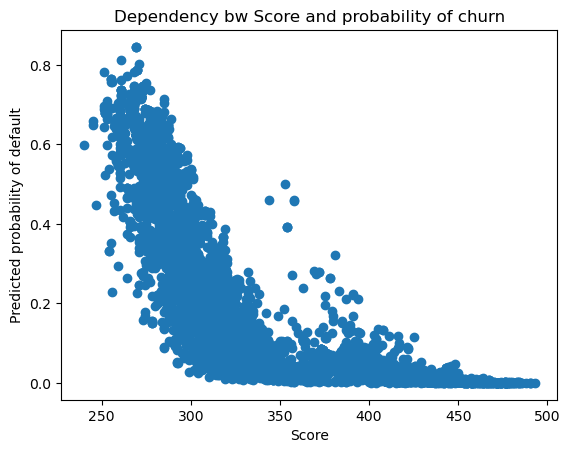

Pearson corr:-0.8249965773104025
 Spearman corr: -0.9455685070224708


In [51]:
# Scoring analysis
plt.scatter(x_Test['Score'], x_Test['Prob'])
plt.xlabel('Score')
plt.ylabel('Predicted probability of default')
plt.title('Dependency bw Score and probability of churn')
plt.show()
pearson_corr, _ = pearsonr(x_Test['Score'], x_Test['Prob'])
spearman_corr, _ = spearmanr(x_Test['Score'], x_Test['Prob'])
print(f"Pearson corr:{pearson_corr}\n Spearman corr: {spearman_corr}")

#### Final dataset composition
- as in SAS the final report will contain
- scorecard, cramer_v, pairwise cramer_v, IV values, Pearson, SPearman, scorecard and excel with score for each client and his probability of attrition
- **TBD**!

In [62]:
x_Test

,age_D,Product_Count_D,mt_ret_gab0_D,nb_ret_ag0_D,mt_ret_ag0_D,mt_ret_ag3_D,mt_ret_ag12_D,nb_vir_e0_D,mt_vir_e0_D,mt_vir_e3_D,...,mt_vir_r0_D,encours_ccQ0Q1_D,engag_pretsQ0Q1_D,Domiciliation_Flag,top_det_bad,top_det_carte,top_det_cc,top_det_pret,Score,Prob
16864,3,4,1,1,1,1,6,1,1,1,...,3,5,3,0,0,0,1,1,260.0,0.529177
18255,3,5,4,1,1,1,6,3,5,6,...,2,5,3,2,1,1,1,0,330.0,0.089753
13331,4,5,1,1,1,1,1,3,5,6,...,3,3,3,0,1,0,1,1,265.0,0.704023
7520,4,6,1,3,4,4,6,3,5,6,...,2,5,6,2,1,0,1,1,451.0,0.003267
26343,3,4,1,6,4,4,4,1,1,1,...,2,3,3,0,0,1,1,0,329.0,0.022963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24084,4,3,1,1,1,1,1,1,1,1,...,3,3,3,0,0,0,1,0,267.0,0.714839
4419,4,6,1,1,1,1,1,3,5,6,...,2,3,5,2,1,0,1,1,316.0,0.062488
20253,3,6,5,1,1,1,1,3,5,6,...,3,5,6,0,1,1,1,1,419.0,0.012081
27928,3,5,5,1,1,1,5,3,5,6,...,2,5,3,2,1,1,1,0,326.0,0.065680


In [84]:
conda install  matplotlib

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.10            |       hd590300_0         542 KB  https://nexus3.kb.cz/repository/anaconda-all
    attr-2.5.1                 |       h166bdaf_1          69 KB  https://nexus3.kb.cz/repository/anaconda-all
    brotli-1.1.0               |       hd590300_1          19 KB  https://nexus3.kb.cz/repository/anaconda-all
    brotli-bin-1.1.0           |       hd590300_1          19 KB  https://nexus3.kb.cz/repository/anaconda-all
    ca-certificates-2023.11.17 |       hbcca054_0  

In [104]:
pip install matplotlib==3.7

Looking in indexes: https://nexus3.kb.cz/repository/pypi-all/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.9 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.1 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.0 which is incompatible.
ydata-profiling 4.6.1 requires pandas!=1.4.0,<2.1,>1.1, but you have pandas 2.1.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#module 'matplotlib.cbook' has no attribute 'mplDeprecation'
tp.ProfileReport(x_Test)

In [ ]:
ProfileReport.mp

In [114]:
import ydata_profiling as tp
import matplotlib.cbook as mp

In [ ]:
#tp.profile_report
mp.mpl

In [59]:
dataframes_tb_reported = {'Kruskal' : kruskal_df, 'Cramer\'s V with respect to target' : cramer_v_df, 'Information Value' : iv_df, 'VIF' : VIF_df, 'Pearson': Pearson_df, 'Scorecard':scorecard_df }
# add validation dataset
with pd.ExcelWriter('auxiliary-report.xlsx') as writer:
    for sheet_name, df in dataframes_tb_reported.items():
        df.to_excel(writer, sheet_name = sheet_name, index = False)
